## Importes

In [1]:
# Utils
import pandas as pd
import warnings
from pathlib import Path

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

## Configurações

In [2]:
# Caminhos
data_path = Path('../data/01_samples')
save_data_path = Path('../data/02_outputs')

## Funções Auxiliares

In [3]:
## Tratamento de dados

# Função para padronizar os nomes entre as bases de partidas e ranking ECO
country_dict = {'North Ireland':'Northern Ireland',
                'Qatar':'United Arab Emirates',
                'Bosnia/Herzeg':'Bosnia and Herzegovina',
                'Czechia':'Czech Republic',
                'Ireland':'Republic of Ireland',
                'Trinidad/Tob': 'Trinidad and Tobago',
                'Serbia/Mont':'Serbia and Montenegro'}

def fix_country_name(data):
    
    if data['team'] in country_dict.keys():
        return country_dict[data['team']]
        
    else:
        return data['team']
    
def fix_missing_score(data, feature):
    
    base_col = '{f}_team_name'
    
    if data[base_col.format(f=feature)] == 'West Germany' and data['year'] == 1990:
        return 2082
    
    elif data[base_col.format(f=feature)] == 'Serbia and Montenegro' and data['year'] == 2006:
        return 1690
    
    else:
        return data['{f}_score'.format(f=feature)]

def fix_missing_rank(data, feature):
    
    base_col = '{f}_team_name'
    
    if data[base_col.format(f=feature)] == 'West Germany' and data['year'] == 1990:
        return 1
    
    elif data[base_col.format(f=feature)] == 'Serbia and Montenegro' and data['year'] == 2006:
        return 40
    
    else:
        return data['{f}_rank'.format(f=feature)]

## visualização

def show_percentage_on_plot(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height() + p.get_height()/80
        ax.annotate(percentage, (x, y), size = 12)
        
def show_number_on_plot(ax):
    for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height() + p.get_height()/80))
       


## Dados Partidas

Dados obtidos no GitHub, dados de partidas de todas as copas, foram coletados por Joshua C. Fjelstul.
Será feita uma análise inicial para tentar encontrar algum insight e assim decidir para que caminho irá a modelagem.

In [4]:
df_matches = pd.read_csv(data_path / 'Joshua_C_Fjelstul/matches.csv', usecols=['match_date', 
                                                                               'home_team_name', 
                                                                               'away_team_name',
                                                                               'home_team_score', 
                                                                               'away_team_score'])
df_matches.dropna(inplace=True)
df_matches['match_date'] = pd.to_datetime(df_matches['match_date'])
df_matches['year'] = df_matches['match_date'].dt.year
df_matches.head()

,match_date,home_team_name,away_team_name,home_team_score,away_team_score,year
0,1930-07-13,France,Mexico,4,1,1930
1,1930-07-13,United States,Belgium,3,0,1930
2,1930-07-14,Yugoslavia,Brazil,2,1,1930
3,1930-07-14,Romania,Peru,3,1,1930
4,1930-07-15,Argentina,France,1,0,1930


In [5]:
# Separando os times para ver a evolução pelas copas
df_temp_1 = df_matches[['year', 'home_team_name', 'home_team_score', 'away_team_score']]
df_temp_2 = df_matches[['year', 'away_team_name', 'away_team_score', 'home_team_score']]

df_temp_1.rename(columns={'home_team_name': 'team', 
                          'home_team_score':'score', 
                          'away_team_score':'score_against'}, inplace=True)
df_temp_2.rename(columns={'away_team_name': 'team', 
                          'away_team_score':'score', 
                          'home_team_score':'score_against'}, inplace=True)

df_scores = pd.concat([df_temp_1, df_temp_2], ignore_index=True)

del df_temp_1, df_temp_2

In [6]:
# Criando um DataFrame com as médias de gols por partida por copa de cada País
df_grouped = df_scores.groupby(['team', 'year'], as_index=False).mean()
df_grouped.sort_values(['team', 'year'], inplace=True)

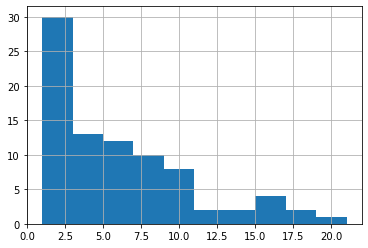

In [7]:
df_grouped.team.value_counts().hist();

É possível observar que muitos países participaram apenas 1 vez da Copa.

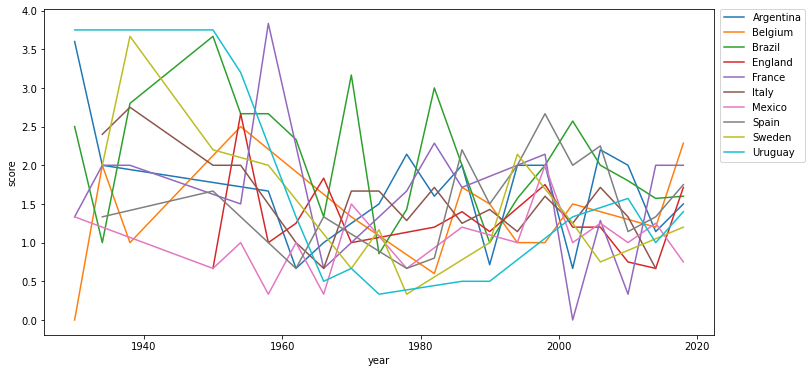

In [8]:
# Mean Score evolution line Plot of the most frequent countries

df_grouped['freq_country'] = df_grouped.groupby('team')['team'].transform('count')
df_grouped['n_participation'] = df_grouped.groupby('team')['team'].transform('cumcount')
df_grouped_plot = df_grouped[df_grouped['freq_country']>=12]

fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(12)

sns.lineplot(data=df_grouped_plot, x="year", y="score", hue='team')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

plt.show()

A Média de gols que o time faz por partida dos Países que mais participaram de copas do Mundo se aproximou com o passar do tempo.

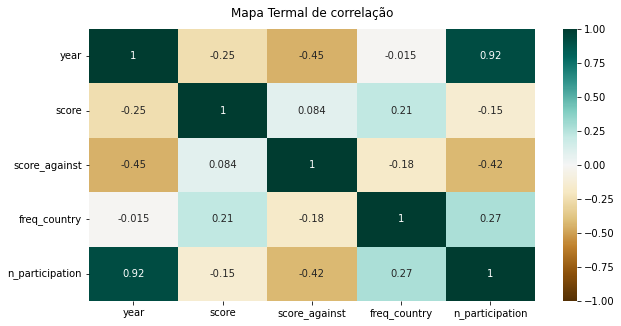

In [9]:
# Ánalise de correlação países com mais participações em copas
df_corr = df_grouped_plot.corr()

plt.figure(figsize = (10,5))
corplot = sns.heatmap(df_corr, vmin = -1, vmax = 1, annot = True, cmap='BrBG')
corplot.set_title('Mapa Termal de correlação', 
                  fontdict={'fontsize':12}, 
                  pad=12);

A Média de Gols que um time faz por partida tem uma correlação negativa com o passar dos anos, mas tem uma correlação positiva com o número de vezes que determinado país participou da copa.

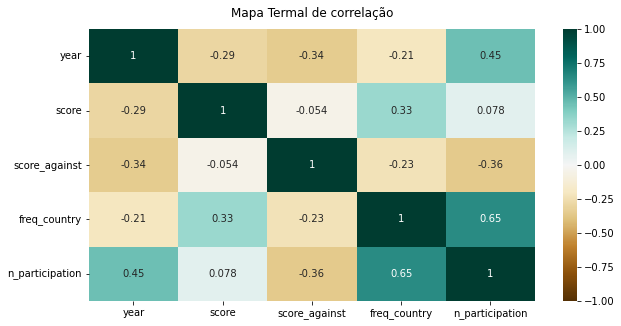

In [10]:
# Ánalise de correlação Geral
df_corr = df_grouped.corr()

plt.figure(figsize = (10,5))
corplot = sns.heatmap(df_corr, vmin = -1, vmax = 1, annot = True, cmap='BrBG')
corplot.set_title('Mapa Termal de correlação', 
                  fontdict={'fontsize':12}, 
                  pad=12);

Quando Analisamos todos os países os comportamentos analisados para os países com mais participações se acentua.
É possível aferir que existe uma relação temporal

In [11]:
df_grouped = df_grouped[['team', 'year', 'n_participation']]

## Dados Rank ELO

Dados coletados via script diramente do site https://www.eloratings.net.
As classificações Elo do futebol mundial são baseadas no sistema de classificação Elo, desenvolvido pelo Dr. Arpad Elo. Este sistema é usado pela FIDE, a federação internacional de xadrez, para classificar os jogadores de xadrez.

Elaratings.net aplica o sistema de classificação Elo ao futebol internacional, adicionando uma ponderação para o tipo de jogo, um ajuste para a vantagem do time da casa e um ajuste para diferença de gols no resultado da partida.

As classificações levam em consideração todas as partidas internacionais "A" para as quais os resultados podem ser encontrados. Os dados de futebol internacional são obtidos principalmente em rsssf.com, theroonba.com e soccer-db.info.

As classificações tendem a convergir para a verdadeira força de uma equipe em relação aos seus concorrentes após cerca de 30 partidas. As classificações para equipes com menos de 30 partidas são consideradas provisórias.

In [12]:
df_elo_ranking = pd.read_csv(data_path / 'scraped/elo_scores.csv')
df_elo_ranking['team'] = df_elo_ranking.apply(fix_country_name, axis=1)
df_elo_ranking.head()

,rank,team,score,year
0,1,Argentina,2062,1930
1,2,Uruguay,2037,1930
2,3,Scotland,1999,1930
3,4,England,1992,1930
4,5,Italy,1965,1930


In [13]:
df_ranking_home = df_elo_ranking.rename(columns={'team':'home_team_name'})
df_ranking_away = df_elo_ranking.rename(columns={'team':'away_team_name'})

In [14]:
## Adicionando as informações do ranking elo nas partidas

# Time da "casa"
df_matches = df_matches.merge(df_ranking_home, on=['home_team_name', 'year'], how='left')
df_matches.rename(columns={'rank':'home_rank','score':'home_score'}, inplace=True)

# Time 'visitante'
df_matches = df_matches.merge(df_ranking_away, on=['away_team_name', 'year'], how='left')
df_matches.rename(columns={'rank':'away_rank','score':'away_score'}, inplace=True)

df_matches.head()

,match_date,home_team_name,away_team_name,home_team_score,away_team_score,year,home_rank,home_score,away_rank,away_score
0,1930-07-13,France,Mexico,4,1,1930,35.0,1566.0,41.0,1497.0
1,1930-07-13,United States,Belgium,3,0,1930,14.0,1762.0,31.0,1593.0
2,1930-07-14,Yugoslavia,Brazil,2,1,1930,25.0,1658.0,9.0,1890.0
3,1930-07-14,Romania,Peru,3,1,1930,37.0,1544.0,42.0,1496.0
4,1930-07-15,Argentina,France,1,0,1930,1.0,2062.0,35.0,1566.0


In [15]:
# Adicionando número da Participação do time
df_matches = df_matches.merge(df_grouped.rename(columns={'team': 'home_team_name',
                                                        'n_participation':'home_n_participation'}),
                              on=['home_team_name','year'], how='left')


df_matches = df_matches.merge(df_grouped.rename(columns={'team': 'away_team_name',
                                                        'n_participation':'away_n_participation'}),
                              on=['away_team_name','year'], how='left')

In [16]:
# Corrigindo dados
df_matches['home_score'] = df_matches.apply(fix_missing_score, feature='home',axis=1)
df_matches['home_rank'] = df_matches.apply(fix_missing_rank, feature='home',axis=1)

df_matches['away_score'] = df_matches.apply(fix_missing_score, feature='away',axis=1)
df_matches['away_rank'] = df_matches.apply(fix_missing_rank, feature='away',axis=1)

In [17]:
# Campos Calculados
df_matches['home_winner'] = df_matches.apply(lambda x: 
                                             1 if x['home_team_score'] > x['away_team_score'] else 0, axis=1)
df_matches['draw'] = df_matches.apply(lambda x: 
                                             1 if x['home_team_score'] == x['away_team_score'] else 0, axis=1)
df_matches['away_winner'] = df_matches.apply(lambda x: 
                                             1 if x['home_team_score'] < x['away_team_score'] else 0, axis=1)

In [18]:
df_matches[['home_winner','draw','away_winner']].value_counts()

home_winner  draw  away_winner
1            0     0              495
0            0     1              206
             1     0              199
dtype: int64

temos uma relação de registro de 701 não empates para 199 empates

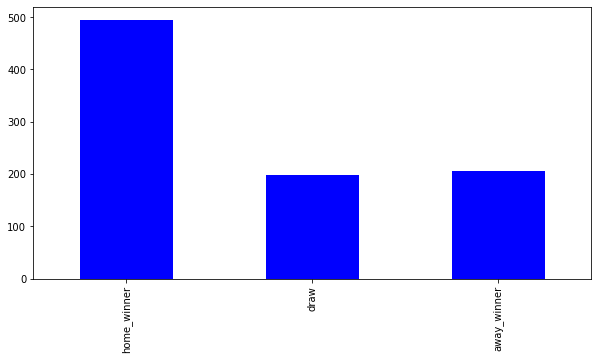

In [19]:
plt.figure(figsize = (10,5))

df_matches[['home_winner','draw','away_winner']].sum().plot.bar(color='blue');

In [20]:
df_matches['rank_diff'] = df_matches.apply(lambda x:
                                           x['home_rank'] - x['away_rank'], axis = 1) 

df_matches['team_score_diff'] = df_matches.apply(lambda x:
                                                 x['home_team_score'] - x['away_team_score'], axis=1)

df_matches['score_diff'] = df_matches.apply(lambda x:
                                            x['home_score'] - x['away_score'], axis=1)

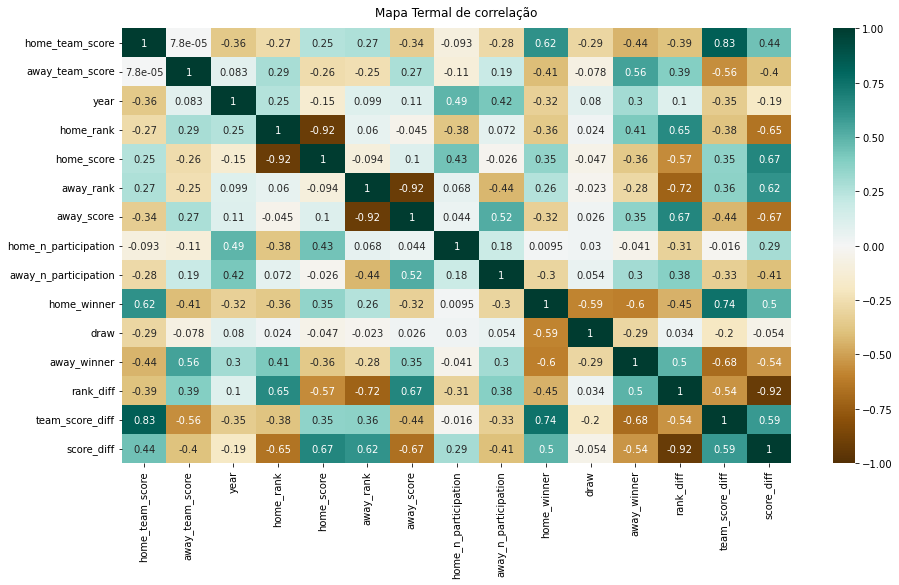

In [21]:
# Ánalise de correlação Geral
df_corr = df_matches.corr()

plt.figure(figsize = (15,8))
corplot = sns.heatmap(df_corr, vmin = -1, vmax = 1, annot = True, cmap='BrBG')
corplot.set_title('Mapa Termal de correlação', 
                  fontdict={'fontsize':12}, 
                  pad=12);

Aqui Conseguimos Observar correlações interessantes entre a número de gols feitos, diferença do número de gols e a diferença de pontuação e ranking ELO, isso mostra que existe uma forte coerencia entre a pontuação do time dada pelo ranking e sua real força. <br><br>
Vamos verificar quantas vezes um time com ranking pior conseguiu vencer:

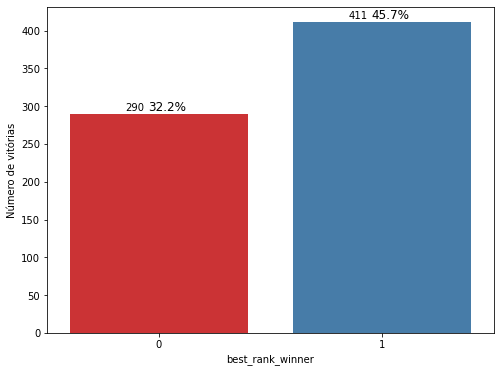

In [22]:
# Criando a coluna que sinaliza quando esse evento aconteceu
df_matches['best_rank_winner'] = df_matches.apply(lambda x: 
                                                  1 if (x['home_winner'] == 1 and x['rank_diff'] < 0) 
                                                  else 0, axis =1)
# gráfico
plt.figure(1, figsize = (8, 6))
ax = sns.countplot(x = 'best_rank_winner', 
                   data = df_matches[df_matches['draw'] == 0], # aqui desconsideramos os empates
                   palette = 'Set1')
plt.ylabel('Número de vitórias')

show_number_on_plot(ax)
show_percentage_on_plot(ax, df_matches['best_rank_winner'])
    
plt.show()

32% das vezes um time melhor rankeado pela métrica ELO perdeu, 46% das vezes o time venceu e 22% das vezes um empate aconteceu.<br>
Até o momento nada contraintuitivo.

vamos ver a diferença de gols versos a diferença de pontos:

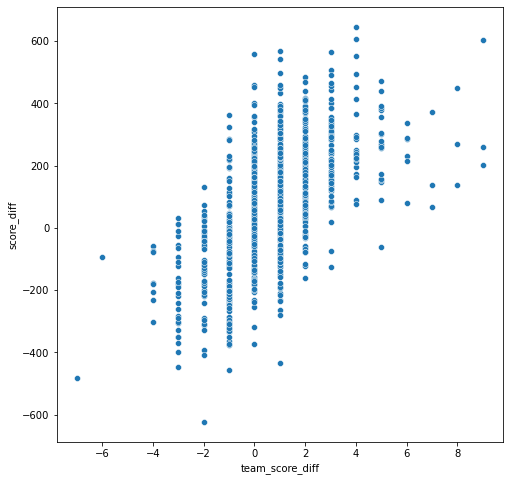

In [23]:
# gráfico
plt.figure(1, figsize = (8, 8))
sns.scatterplot(data=df_matches, y="score_diff", x="team_score_diff")
plt.show()

É possível observar uma relação direta entra a diferença de pontos e a diferença de gols entre as equipes! <br>
Também é possível observar que nenhum time com uma diferença superior a 400 pontos do rank elo perdeu para o time adversário.

Relação entre número de gols feitos e o Ranking:

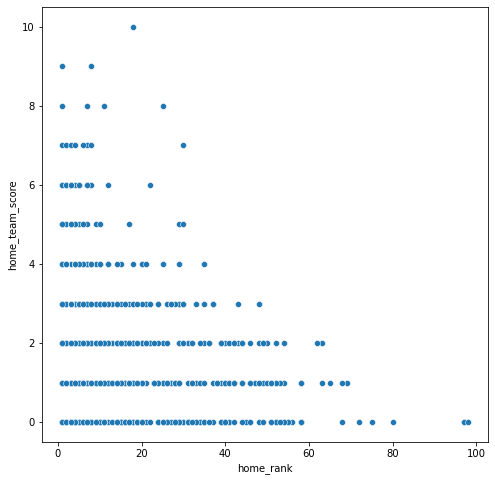

In [24]:
# gráfico
plt.figure(1, figsize = (8, 8))
sns.scatterplot(data=df_matches, y="home_team_score", x="home_rank")
plt.show()

Quanto mais próximo do primeiro lugar, maiores a quantidades de gol por partida.

Já é possível ter uma idéia de como os dados do ranking ELO e os dados históricos das copas se relacionam, agora serão feitos alguns testes de modelagem e avaliação de diferentes tipos de modelos.

In [26]:
# Salvando os dados
df_matches.to_csv(save_data_path / '01_matches_eco_score.csv', index=False)